In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.stats import pearsonr, spearmanr
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
yrs = []
cts = []
pstr = 0.001
with open("../Data/mfpairs_similarity.csv","r") as f:
    print (next(f))
    for l in f.readlines():
        data = l.split(",")
        y1 = int(data[4])
        y2 = int(data[5])
        k1 = int(data[8])
        k2 = int(data[9])
        q = float(data[7])
        g1 = data[2]
        g2 = data[3]
        if q < pstr:
            assert g1 != g2
            if g1 == "male":
                yrs.append(y1-y2)
                cts.append(k1-k2)
            elif g1 == "female":
                yrs.append(y2-y1)
                cts.append(k2-k1)
            else:
                print ("WTF",g1)

paper1,paper2,gender1,gender2,year1,year2,keyval,qval,count1,count2,countd,yeard



### Compute correlation

In [3]:
yrs = np.array(yrs)
cts = np.array(cts)
print ("pearson",pearsonr(cts,yrs), spearmanr(cts,yrs))

pearson (-0.1258778440900454, 0.0) SpearmanrResult(correlation=-0.3438865436407616, pvalue=0.0)


### Compute probability distributions and probability anomaly

In [4]:
cts_xd, cts_yd = zip(*list(Counter(cts).items()))
cts_xd = np.array(cts_xd)
cts_yd = np.array(cts_yd)
cts_yd = cts_yd/(1.0*sum(cts_yd))

yrs_xd, yrs_yd = zip(*list(Counter(yrs).items()))
yrs_xd = np.array(yrs_xd)
yrs_yd = np.array(yrs_yd)
yrs_yd = yrs_yd/(1.0*sum(yrs_yd))

In [5]:
joint_prob = np.zeros((1+max(cts)-min(cts),1+int(max(yrs)-min(yrs))))

minyr = min(yrs)
maxyr = max(yrs)
minct = min(cts)
maxct = max(cts)

for i, yi in enumerate(yrs):
    ci = cts[i]
    joint_prob[int(ci-minct),int(yi-minyr)] += 1
    
joint_prob = joint_prob / (1.0*np.sum(joint_prob))

In [6]:
joint_prob_IND = np.zeros((1+max(cts)-min(cts),1+int(max(yrs)-min(yrs)))) 

probs_yrs = dict(zip(yrs_xd,yrs_yd))
probs_cts = dict(zip(cts_xd,cts_yd))

for yi in np.arange(minyr,maxyr):
    for ci in np.arange(minct,maxct):
        ci_ind, yi_ind = int(ci-minct),int(yi-minyr)
        try:
            Pij = probs_cts[ci] * probs_yrs[yi]
        except KeyError:
            Pij = 0.0
        joint_prob_IND[ci_ind,yi_ind] = Pij

In [7]:
joint_prob_DIFF = (joint_prob-joint_prob_IND)/joint_prob_IND

### Visualization

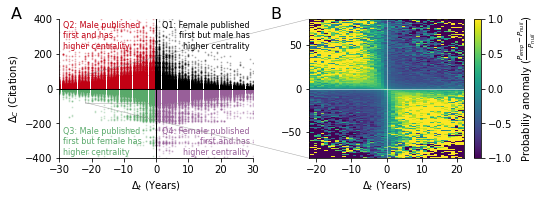

In [8]:
plt.figure(figsize=(2.0*.48*8,.48*6))

ax=plt.subplot(1,2,1)
msk = yrs < 0
msk = np.logical_and(msk,cts<0)
plt.plot(yrs[msk],cts[msk],"o",color="#59A96A",ms=1,alpha=0.2)
plt.text(-29, -390,
         "Q3: Male published\nfirst but female has\nhigher centrality",
         fontsize=8,
         color="#59A96A",
         ha='left',
         va="bottom",
        zorder=20)


msk = yrs < 0
msk = np.logical_and(msk,cts>0)
plt.plot(yrs[msk],cts[msk],"o",color="#C20114",ms=1,alpha=0.2)
plt.text(-29, 390,
         "Q2: Male published\nfirst and has\nhigher centrality",
         fontsize=8,
         color="#C20114",
         ha='left',
         va="top",
        zorder=20)

msk = yrs >= 0
msk = np.logical_and(msk,cts<0)
plt.plot(yrs[msk],cts[msk],"o",color="#985F99",ms=1,alpha=0.2)
plt.text(29, -390,
         "Q4: Female published\nfirst and has\nhigher centrality",
         fontsize=8,
         color="#985F99",
         ha='right',
         va="bottom",
        zorder=20)

msk = yrs >= 0
msk = np.logical_and(msk,cts>0)
plt.plot(yrs[msk],cts[msk],"o",color="#000000",ms=1,alpha=0.2)
plt.text(29, 390,
         "Q1: Female published\nfirst but male has\nhigher centrality",
         fontsize=8,
         color="#000000",
         ha='right',
         va="top",
        zorder=20)

plt.axvline(0,ls="-",color="k",lw=1)
plt.axhline(0,ls="-",color="k",lw=1)

plt.xlim(-30,30)
plt.ylim(-400,400)
plt.xlabel("$\Delta_t$ (Years)")
plt.ylabel("$\Delta_C$ (Citations)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(-45,400,"A",
         fontsize=16)

ax2 = plt.subplot(1,2,2)
xx = np.arange(minyr-.5,maxyr+.5,1.0)
yy = np.arange(minct-.5,maxct+.5,1.0)
zz = joint_prob_DIFF
plt.pcolormesh(xx,yy,zz,vmin=-1.0,vmax=1.0)
plt.colorbar(label=r"Probabiliy anomaly ($\frac{P_{emp}-P_{null}}{P_{null}}$)")
plt.ylim(-80,80)
plt.xlim(-22,22)
plt.axhline(0,ls="-",color="w",lw=.5)
plt.axvline(0,ls="-",color="w",lw=.5)
plt.xlabel("$\Delta_t$ (Years)")

plt.locator_params(axis='x', nbins=5)
mark_inset(ax, ax2, 
           loc1=2, loc2=3, 
           fc="none", 
           ec="0.5",
           clip_on=True,
           zorder=0,
           in_layout=False,
           alpha=0.7,
          lw=0.5)

plt.text(-33,plt.ylim()[1],"B",
#          weight='bold',
         fontsize=16)

plt.tight_layout()
plt.show()